In [105]:
# See Top Features - Train all models using the best classifier that has coef_ function available
# LinearSVC, in this case.
# Challenges - May only be interested in using the top models indicated by Load_Pickle.ipynb's final_results accuracies.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import nltk
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from math import sqrt
import joblib
import string
import re
import sys
import datetime
import html
import os
import timeit
nltk.download('punkt')
nltk.download('wordnet')

# sklearn=0.23.1, pandas=1.0.1
print(sklearn.__version__)
print(pd.__version__)

0.23.1
1.0.1


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Gather Data

### 2 sources

In [106]:
# Let's see what features we have.
length_req = 800  # Character length requirement for articles
confidence_level = .90

left1 = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left1 = pd.read_csv('Huffington.csv')
print("We have {:,} left1-wing records".format(left1.shape[0]))

left1['date'].fillna("", inplace=True)
left1['article'].fillna("", inplace=True)
    
for x in range(left1.shape[0]):
    if len(left1['article'][x]) < length_req:
        left1.drop(x, inplace=True)

print("We have {:,} left1-wing records > {} characters long".format(left1.shape[0], length_req))

# Only keep the unique article rows and their values
left1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left1.shape[0]))

left1['date'] = left1['date'].str.replace(',', '')

left1.head()

We have 4,355 left1-wing records
We have 4,314 left1-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [107]:
# Let's see what features we have.
right1 = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right1-wing records".format(right1.shape[0]))

right1['date'].fillna("", inplace=True)
right1['article'].fillna("", inplace=True)

for x in range(right1.shape[0]):
    if len(right1['article']) < length_req:
        right1.drop(x, inplace=True)

print("We have {:,} right1-wing records > {} characters long".format(right1.shape[0], length_req))

# Only keep the unique rows and their values
right1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right1.shape[0]))

right1['date'] = right1['date'].str.replace(',', '')

right1.head()

We have 5,829 right1-wing records
We have 5,829 right1-wing records > 800 characters long
5,780 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [108]:
# Check for null values
right1.isnull().sum(axis=0)

date       0
article    0
dtype: int64

In [109]:
left1.isnull().sum(axis=0)

date       0
article    0
dtype: int64

In [110]:
# If there were null values, the below will replace them.
left1['date'].fillna("", inplace=True)
right1['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [111]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left1[~left1['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [112]:
left1['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left1 articles
print("We have {:,} left1-wing records".format(left1.shape[0]))
right1['pole'] = 1
print("We have {:,} right1-wing records".format(right1.shape[0]))

if (right1.shape[0] > left1.shape[0]):
    print("Getting random sample of right1-wing records")
    right1 = right1.sample(left1.shape[0]) # randomly generate samples from right1 equal to left1's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left1-wing records")
    left1 = left1.sample(right1.shape[0]) # randomly generate samples from right1 equal to left1's length. (Can be set to random_state=0)

all_data1 = pd.concat([left1, right1]) # combine left1 and right1 datasets
column_names = all_data1.columns.values
all_data1.columns = column_names
all_data1 = all_data1.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data1['date'] = all_data1['date'].str.replace(',', '')
all_data1.head()

We have 4,304 left1-wing records
We have 5,780 right1-wing records
Getting random sample of right1-wing records


,date,article,pole
0,2020-04-27,Fox News' Hannity Releasing 'Live Free or Die'...,1
1,2020-07-10,Julián And Joaquin Castro’s Stepmother Dies Fr...,0
2,2020-06-27,KFF Poll: Biden Leading Trump by 13 Points Joe...,1
3,2020-06-10,Sen. Graham Defeats 3 GOP Challengers in Quest...,1
4,2020-05-30,NYC Transit Union Backs Bus Drivers Who Refuse...,0


In [113]:
print("{:,} / {:,} Current Records".format(
    all_data1['pole'].sum(),
    all_data1.shape[0]))

# Only keep the unique rows and their values
all_data1.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data1.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data1['pole'].sum(),
    all_data1.shape[0]))

4,304 / 8,608 Current Records
8,608 Records are unique
4,304 / 8,608 Current Records


### 4 sources

In [114]:
left1 = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left1.shape[0]))

for x in range(left1.shape[0]):
    if len(left1['article'][x]) < length_req:
        left1.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left1.shape[0], length_req))

# Only keep the unique article rows and their values
left1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left1.shape[0]))

left1['date'] = left1['date'].str.replace(',', '')

left1.head()

We have 4,355 left-wing records
We have 4,314 left-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [115]:
left2 = pd.read_excel("csvs/Salon.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left2.shape[0]))

left2['date'].fillna("", inplace=True)
left2['article'].fillna("", inplace=True)

for x in range(left2.shape[0]):
    if len(left2['article'][x]) < length_req:
        left2.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left2.shape[0], length_req))

# Only keep the unique article rows and their values
left2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left2.shape[0]))

left2['date'] = left2['date'].str.replace(',', '')

left2.head()

We have 2,303 left-wing records
We have 2,278 left-wing records > 800 characters long
1,987 Records are unique


,date,article
0,2020-01-15,"Lev Parnas, the indicted associate of former N..."
1,2020-01-26,President Donald Trump's comments about Thomas...
2,2020-05-31,This article originally appeared at Common Dre...
3,2020-05-31,Trump admin rush migrant children deportations...
4,2020-05-31,"The late Gore Vidal once confessed, with chara..."


In [116]:
left_min = [left1.shape[0], left2.shape[0]]
left_min_entries = min(left_min)

left1 = left1.sample(left_min_entries)
left2 = left2.sample(left_min_entries)

print("Huffpost: {} entries".format(left1.shape[0]))
print("Salon: {} entries".format(left2.shape[0]))

Huffpost: 1987 entries
Salon: 1987 entries


In [117]:
left = pd.concat([left1, left2])
print("We have {:,} left-wing records".format(left.shape[0]))

We have 3,974 left-wing records


In [118]:
# Let's see what features we have.
right1 = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right1.shape[0]))

#count = right.shape[0]

for x in range(right1.shape[0]):
    if len(right1['article'][x]) < length_req:
        right1.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right1.shape[0], length_req))

# Only keep the unique rows and their values
right1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right1.shape[0]))

right1['date'] = right1['date'].str.replace(',', '')

right1.head()

We have 5,829 right-wing records
We have 5,637 right-wing records > 800 characters long
5,588 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [119]:
right2 = pd.read_excel("csvs/Redstate.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right2.shape[0]))

#count = right.shape[0]

for x in range(right2.shape[0]):
    if len(right2['article'][x]) < length_req:
        right2.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right2.shape[0], length_req))

# Only keep the unique rows and their values
right2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right2.shape[0]))

right2['date'] = right2['date'].str.replace(',', '')

right2.head()

We have 2,270 right-wing records
We have 2,207 right-wing records > 800 characters long
2,111 Records are unique


,date,article
0,2020-01-15,Even CNN Calls Out Democrats For How They Cele...
1,2020-01-26,The Isolation of Connectivity Image by Thom...
2,2020-05-29,Mayor of Minneapolis Lets Rioters Burn Down Po...
3,2020-05-29,Watch: CNN Crew Arrested by MN State Police Li...
4,2020-05-31,Buffalo Mayor Has Best Response to Rioter Who ...


In [120]:
right_min = [right1.shape[0], right2.shape[0]]
right_min_entries = min(right_min)

right1 = right1.sample(right_min_entries)
right2 = right2.sample(right_min_entries)

print("NewsMax: {} entries".format(right1.shape[0]))
print("Redstate: {} entries".format(right2.shape[0]))

NewsMax: 2111 entries
Redstate: 2111 entries


In [121]:
right = pd.concat([right1, right2])
print("We have {:,} right-wing records".format(right.shape[0]))

We have 4,222 right-wing records


In [122]:
# Check for null values
right.isnull().sum(axis=0)

date       6
article    0
dtype: int64

In [123]:
left.isnull().sum(axis=0)

date       0
article    0
dtype: int64

In [124]:
# If there were null values, the below will replace them.
left['date'].fillna("", inplace=True)
right['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [125]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left[~left['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [126]:
left['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left articles
print("We have {:,} left-wing records".format(left.shape[0]))
right['pole'] = 1
print("We have {:,} right-wing records".format(right.shape[0]))

if (right.shape[0] > left.shape[0]):
    print("Getting random sample of right-wing records")
    right = right.sample(left.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left-wing records")
    left = left.sample(right.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)

all_data2 = pd.concat([left, right]) # combine left and right datasets
column_names = all_data2.columns.values
all_data2.columns = column_names
all_data2 = all_data2.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data2['date'] = all_data2['date'].str.replace(',', '')
all_data2.head()

We have 3,974 left-wing records
We have 4,222 right-wing records
Getting random sample of right-wing records


,date,article,pole
0,2020-06-13,Men Screams ‘You’re Choking Me’ As People Hold...,1
1,2020-07-19,"1619 Project Founder Ups Her Racism Game, Deci...",1
2,2020-02-17,Read more articles from the DCReport here. In ...,0
3,2020-05-10,John Podesta Told Lawmakers Payment for Steele...,1
4,2020-07-22,This article originally appeared on Raw Story ...,0


In [127]:
print("{:,} / {:,} Current Records".format(
    all_data2['pole'].sum(),
    all_data2.shape[0]))

# Only keep the unique rows and their values
all_data2.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data2.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data2['pole'].sum(),
    all_data2.shape[0]))

3,974 / 7,948 Current Records
7,948 Records are unique
3,974 / 7,948 Current Records


### 6 sources

In [128]:
left1 = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left1.shape[0]))

for x in range(left1.shape[0]):
    if len(left1['article'][x]) < length_req:
        left1.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left1.shape[0], length_req))

# Only keep the unique article rows and their values
left1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left1.shape[0]))

left1['date'] = left1['date'].str.replace(',', '')

left1.head()

We have 4,355 left-wing records
We have 4,314 left-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [129]:
left2 = pd.read_excel("csvs/Salon.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left2.shape[0]))

left2['date'].fillna("", inplace=True)
left2['article'].fillna("", inplace=True)

for x in range(left2.shape[0]):
    if len(left2['article'][x]) < length_req:
        left2.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left2.shape[0], length_req))

# Only keep the unique article rows and their values
left2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left2.shape[0]))

left2['date'] = left2['date'].str.replace(',', '')

left2.head()

We have 2,303 left-wing records
We have 2,278 left-wing records > 800 characters long
1,987 Records are unique


,date,article
0,2020-01-15,"Lev Parnas, the indicted associate of former N..."
1,2020-01-26,President Donald Trump's comments about Thomas...
2,2020-05-31,This article originally appeared at Common Dre...
3,2020-05-31,Trump admin rush migrant children deportations...
4,2020-05-31,"The late Gore Vidal once confessed, with chara..."


In [130]:
left3 = pd.read_excel("csvs/Rawstory.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left3.shape[0]))

for x in range(left3.shape[0]):
    if len(left3['article'][x]) < length_req:
        left3.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left3.shape[0], length_req))

# Only keep the unique article rows and their values
left3.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left3.shape[0]))

left3['date'] = left3['date'].str.replace(',', '')

left3.head()

We have 1,160 left-wing records
We have 1,159 left-wing records > 800 characters long
1,159 Records are unique


,date,article
0,2020-01-15,‘Uninterested in evidence’: Embattled Susan Co...
1,2020-02-07,Tornado warning issued for 2 New Jersey counti...
2,2020-02-07,Trump official busted for telling ‘blatant lie...
3,2020-02-07,Republicans face ‘Electoral College time bomb’...
4,2020-02-07,We’re a former coal company and we support gov...


In [131]:
left_min = [left1.shape[0], left2.shape[0], left3.shape[0]]
left_min_entries = min(left_min)

left1 = left1.sample(left_min_entries)
left2 = left2.sample(left_min_entries)
left3 = left3.sample(left_min_entries)

print("Huffpost: {} entries".format(left1.shape[0]))
print("Salon: {} entries".format(left2.shape[0]))
print("Rawstory: {} entries".format(left3.shape[0]))

Huffpost: 1159 entries
Salon: 1159 entries
Rawstory: 1159 entries


In [132]:
left = pd.concat([left1, left2, left3])
print("We have {:,} left-wing records".format(left.shape[0]))

We have 3,477 left-wing records


In [133]:
# Let's see what features we have.
right1 = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right1.shape[0]))

#count = right.shape[0]

for x in range(right1.shape[0]):
    if len(right1['article'][x]) < length_req:
        right1.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right1.shape[0], length_req))

# Only keep the unique rows and their values
right1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right1.shape[0]))

right1['date'] = right1['date'].str.replace(',', '')

right1.head()

We have 5,829 right-wing records
We have 5,637 right-wing records > 800 characters long
5,588 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [134]:
right2 = pd.read_excel("csvs/Redstate.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right2.shape[0]))

#count = right.shape[0]

for x in range(right2.shape[0]):
    if len(right2['article'][x]) < length_req:
        right2.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right2.shape[0], length_req))

# Only keep the unique rows and their values
right2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right2.shape[0]))

right2['date'] = right2['date'].str.replace(',', '')

right2.head()

We have 2,270 right-wing records
We have 2,207 right-wing records > 800 characters long
2,111 Records are unique


,date,article
0,2020-01-15,Even CNN Calls Out Democrats For How They Cele...
1,2020-01-26,The Isolation of Connectivity Image by Thom...
2,2020-05-29,Mayor of Minneapolis Lets Rioters Burn Down Po...
3,2020-05-29,Watch: CNN Crew Arrested by MN State Police Li...
4,2020-05-31,Buffalo Mayor Has Best Response to Rioter Who ...


In [135]:
right3 = pd.read_excel("csvs/WashingtonExaminer.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right3.shape[0]))

#count = right.shape[0]

for x in range(right3.shape[0]):
    if len(right3['article'][x]) < length_req:
        right3.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right3.shape[0], length_req))

# Only keep the unique rows and their values
right3.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right3.shape[0]))

right3['date'] = right3['date'].str.replace(',', '')

right3.head()

We have 1,117 right-wing records
We have 1,104 right-wing records > 800 characters long
983 Records are unique


,date,article
0,2020-01-16,'No one's giggling around here': Democrats def...
1,2020-02-19,Bloomberg would sell business and financial in...
2,2020-02-19,Uncertainty reigns over Democratic presidentia...
3,2020-02-19,Five things to watch in the Nevada Democratic ...
4,2020-02-19,'Some guy wearing a dress': Bloomberg once cal...


In [136]:
right_min = [right1.shape[0], right2.shape[0], right3.shape[0]]
right_min_entries = min(right_min)

right1 = right1.sample(right_min_entries)
right2 = right2.sample(right_min_entries)
right3 = right3.sample(right_min_entries)

print("NewsMax: {} entries".format(right1.shape[0]))
print("Redstate: {} entries".format(right2.shape[0]))
print("WashingtonExaminer: {} entries".format(right3.shape[0]))

NewsMax: 983 entries
Redstate: 983 entries
WashingtonExaminer: 983 entries


In [137]:
right = pd.concat([right1, right2, right3])
print("We have {:,} right-wing records".format(right.shape[0]))

We have 2,949 right-wing records


In [138]:
# Check for null values
right.isnull().sum(axis=0)

date       3
article    0
dtype: int64

In [139]:
left.isnull().sum(axis=0)

date       9
article    0
dtype: int64

In [140]:
# If there were null values, the below will replace them.
left['date'].fillna("", inplace=True)
right['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [141]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left[~left['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [142]:
left['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left articles
print("We have {:,} left-wing records".format(left.shape[0]))
right['pole'] = 1
print("We have {:,} right-wing records".format(right.shape[0]))

if (right.shape[0] > left.shape[0]):
    print("Getting random sample of right-wing records")
    right = right.sample(left.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left-wing records")
    left = left.sample(right.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
    
all_data3 = pd.concat([left, right]) # combine left and right datasets
column_names = all_data3.columns.values
all_data3.columns = column_names
all_data3 = all_data3.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data3['date'] = all_data3['date'].str.replace(',', '')
all_data3.head()

We have 3,477 left-wing records
We have 2,949 right-wing records
Getting random sample of left-wing records


,date,article,pole
0,2020-06-14,A Call for the Redistribution of Wealth Inside...,1
1,2020-06-28,At emergency COVID meeting Pence praises Texas...,0
2,2020-01-26,"President Donald Trump was accused of ""jury ta...",0
3,2020-05-17,Trump loyalist secretly slams president behind...,0
4,2020-06-09,Chicago Woman Goes BALLISTIC Because Shop Owne...,1


In [143]:
print("{:,} / {:,} Current Records".format(
    all_data3['pole'].sum(),
    all_data3.shape[0]))

# Only keep the unique rows and their values
all_data3.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data3.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data3['pole'].sum(),
    all_data3.shape[0]))

2,949 / 5,898 Current Records
5,898 Records are unique
2,949 / 5,898 Current Records


In [144]:
print("2 sources: {} unique, current records".format(all_data1.shape[0]))
print("4 sources: {} unique, current records".format(all_data2.shape[0]))
print("6 sources: {} unique, current records".format(all_data3.shape[0]))

2 sources: 8608 unique, current records
4 sources: 7948 unique, current records
6 sources: 5898 unique, current records


In [145]:
# 3 dataframes
all_dataframes = [all_data1, all_data2, all_data3]
all_dataframes[0].head()

,date,article,pole
0,2020-04-27,Fox News' Hannity Releasing 'Live Free or Die'...,1
1,2020-07-10,Julián And Joaquin Castro’s Stepmother Dies Fr...,0
2,2020-06-27,KFF Poll: Biden Leading Trump by 13 Points Joe...,1
3,2020-06-10,Sen. Graham Defeats 3 GOP Challengers in Quest...,1
4,2020-05-30,NYC Transit Union Backs Bus Drivers Who Refuse...,0


In [146]:
# Remove years and digits from being used as features
def remove_years(text):
    text = re.sub(r"[0-9]{4}", " ", text)
    text = re.sub(r"[0-9]{3}", " ", text)
    text = re.sub(r"[0-9]{2}", " ", text)
    text = re.sub(r"[0-9]{1}", " ", text)
    text = re.sub(r"[0-9]{4}ish", " ", text)
    text = re.sub(r"[0-9]{3}ish", " ", text)
    text = re.sub(r"[0-9]{2}ish", " ", text)
    text = re.sub(r"[0-9]{1}ish", " ", text)
    text = re.sub(r"2020-[0-9]{2}-[0-9]{2}", " ", text)
    return text

In [147]:
# Proper Noun Removal function
# Do this before lowercasing all text
from nltk.tag import pos_tag

def proper_noun_removal(text):
    tagged_sent = pos_tag(text.split())
    return [w for w, pos in tagged_sent if pos != 'NNP']

In [148]:
# Lemmatization after Word Tokenization
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

In [149]:
# Clean each dataframe's data.
for all_data in all_dataframes:
    
    # URL decoding function for decoding any string of html characters...
    all_data['article'] = all_data['article'].astype(str).apply(lambda x: html.unescape(x))
    
    # Store the original comments in a new column
    all_data['unfiltered_articles'] = all_data['article'].values
    all_data['unfiltered_articles_lowercase'] = all_data['article'].values
    all_data['article_PNremoved'] = all_data['article'].values

all_dataframes[0].head()

,date,article,pole,unfiltered_articles,unfiltered_articles_lowercase,article_PNremoved
0,2020-04-27,Fox News' Hannity Releasing 'Live Free or Die'...,1,Fox News' Hannity Releasing 'Live Free or Die'...,Fox News' Hannity Releasing 'Live Free or Die'...,Fox News' Hannity Releasing 'Live Free or Die'...
1,2020-07-10,Julián And Joaquin Castro’s Stepmother Dies Fr...,0,Julián And Joaquin Castro’s Stepmother Dies Fr...,Julián And Joaquin Castro’s Stepmother Dies Fr...,Julián And Joaquin Castro’s Stepmother Dies Fr...
2,2020-06-27,KFF Poll: Biden Leading Trump by 13 Points Joe...,1,KFF Poll: Biden Leading Trump by 13 Points Joe...,KFF Poll: Biden Leading Trump by 13 Points Joe...,KFF Poll: Biden Leading Trump by 13 Points Joe...
3,2020-06-10,Sen. Graham Defeats 3 GOP Challengers in Quest...,1,Sen. Graham Defeats 3 GOP Challengers in Quest...,Sen. Graham Defeats 3 GOP Challengers in Quest...,Sen. Graham Defeats 3 GOP Challengers in Quest...
4,2020-05-30,NYC Transit Union Backs Bus Drivers Who Refuse...,0,NYC Transit Union Backs Bus Drivers Who Refuse...,NYC Transit Union Backs Bus Drivers Who Refuse...,NYC Transit Union Backs Bus Drivers Who Refuse...


In [150]:
# Clean each dataframe's data
removal = ["article", "article_PNremoved"]

for all_data in all_dataframes:
    for column in removal:
        # Clean the text
        # The apostrophes here are very specific.
        # The regular ' will not work from keyboard.
        # You have to use print(all_data.head()) and copy and paste that apostrophe into the str.replace()
        all_data[column] = all_data[column].str.lower()
        all_data[column] = all_data[column].str.replace(r"u.s.", "united states")
        all_data[column] = all_data[column].str.replace(r"what’s", "what is")
        all_data[column] = all_data[column].str.replace(r"’s", " ")
        all_data[column] = all_data[column].str.replace(r"’ve", "have")
        all_data[column] = all_data[column].str.replace(r"’re", "are")
        all_data[column] = all_data[column].str.replace(r"’ll", "will")
        all_data[column] = all_data[column].str.replace(r"can’t", "can not")
        all_data[column] = all_data[column].str.replace(r"aren’t", "are not")
        all_data[column] = all_data[column].str.replace(r"couldn’t", "could not")
        all_data[column] = all_data[column].str.replace(r"didn’t", "did not")
        all_data[column] = all_data[column].str.replace(r"doesn’t", "does not")
        all_data[column] = all_data[column].str.replace(r"don’t", "do not")
        all_data[column] = all_data[column].str.replace(r"hadn’t", "had not")
        all_data[column] = all_data[column].str.replace(r"hasn’t", "has not")
        all_data[column] = all_data[column].str.replace(r"haven’t", "have not")
        all_data[column] = all_data[column].str.replace(r"isn’t", "is not")
        all_data[column] = all_data[column].str.replace(r"shouldn’t", "should not")
        all_data[column] = all_data[column].str.replace(r"wasn’t", "was not")
        all_data[column] = all_data[column].str.replace(r"weren’t", "were not")
        all_data[column] = all_data[column].str.replace(r"won’t", "will not")
        all_data[column] = all_data[column].str.replace(r"wouldn’t", "would not")
        all_data[column] = all_data[column].str.replace(r"mustn’t", "must not")
        all_data[column] = all_data[column].str.replace(r"i’m", "i am")

        # As are these apostrophes...
        all_data[column] = all_data[column].str.replace(r"what's", "what is")
        all_data[column] = all_data[column].str.replace(r"'s", " ")
        all_data[column] = all_data[column].str.replace(r"'ve", "have")
        all_data[column] = all_data[column].str.replace(r"'re", "are")
        all_data[column] = all_data[column].str.replace(r"'ll", "will")
        all_data[column] = all_data[column].str.replace(r"can't", "can not")
        all_data[column] = all_data[column].str.replace(r"aren't", "are not")
        all_data[column] = all_data[column].str.replace(r"couldn't", "could not")
        all_data[column] = all_data[column].str.replace(r"didn't", "did not")
        all_data[column] = all_data[column].str.replace(r"doesn't", "does not")
        all_data[column] = all_data[column].str.replace(r"don't", "do not")
        all_data[column] = all_data[column].str.replace(r"hadn't", "had not")
        all_data[column] = all_data[column].str.replace(r"hasn't", "has not")
        all_data[column] = all_data[column].str.replace(r"haven't", "have not")
        all_data[column] = all_data[column].str.replace(r"isn't", "is not")
        all_data[column] = all_data[column].str.replace(r"shouldn't", "should not")
        all_data[column] = all_data[column].str.replace(r"wasn't", "was not")
        all_data[column] = all_data[column].str.replace(r"weren't", "were not")
        all_data[column] = all_data[column].str.replace(r"won't", "will not")
        all_data[column] = all_data[column].str.replace(r"wouldn't", "would not")
        all_data[column] = all_data[column].str.replace(r"mustn't", "must not")
        all_data[column] = all_data[column].str.replace(r"i'm", "i am")
        #print(all_data.head())

        # Custom word removal - these appear too frequently and do not help with generalization.
        custom = {"donald j trump", "donald j. trump", "donald john trump", 'newsmax', 'redstate', 'washingtonexaminer', 'washington examiner', 
                  "huffpost", 'salon', 'rawstory', 'raw story',
                  "___", "donald trump", "trump", "pelosi"}

        # Did not work
        #for word in custom:
        #    all_data["article"]= all_data["article"].replace(word, " ") 

        # Did not work
        #all_data[column] = all_data[column].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom)]))

        # Did work
        #def customWord(text):
        #    custom = {"huffpost", "newsmax"}
        #    return text.replace("huffpost", " ") 

        for word in custom:
            all_data[column] = all_data[column].apply(lambda x: x.replace(word, " "))

        # Check to see the words were replaced
        #print(all_data[all_data[column].str.contains("newsmax")])

        # Remove years and digits from being used as features
        all_data[column] = all_data[column].apply(lambda x: remove_years(x))
        #print(all_data.head())

        # Punctuation removal - CountVectorizer() does this for you
        #punctuation = {'.', ':', ';', "\'", '\"', '!', '?', "\’", '(', ')', '-'}

        #print(all_data[all_data[column].str.contains("19")])
        
        # Lowercase the unfiltered_articles_lowercase column's text
        all_data["unfiltered_articles_lowercase"] = all_data["unfiltered_articles_lowercase"].str.lower()


all_dataframes[0].head()

,date,article,pole,unfiltered_articles,unfiltered_articles_lowercase,article_PNremoved
0,2020-04-27,fox news' hannity releasing 'live free or die'...,1,Fox News' Hannity Releasing 'Live Free or Die'...,fox news' hannity releasing 'live free or die'...,fox news' hannity releasing 'live free or die'...
1,2020-07-10,julián and joaquin castro stepmother dies fro...,0,Julián And Joaquin Castro’s Stepmother Dies Fr...,julián and joaquin castro’s stepmother dies fr...,julián and joaquin castro stepmother dies fro...
2,2020-06-27,kff poll: biden leading by points joe bide...,1,KFF Poll: Biden Leading Trump by 13 Points Joe...,kff poll: biden leading trump by 13 points joe...,kff poll: biden leading by points joe bide...
3,2020-06-10,sen. graham defeats gop challengers in qunit...,1,Sen. Graham Defeats 3 GOP Challengers in Quest...,sen. graham defeats 3 gop challengers in quest...,sen. graham defeats gop challengers in qunit...
4,2020-05-30,nyc transit union backs bus drivers who refuse...,0,NYC Transit Union Backs Bus Drivers Who Refuse...,nyc transit union backs bus drivers who refuse...,nyc transit union backs bus drivers who refuse...


In [151]:
# CountVectorizers for onegram, bigram, trigram
# Does not work as intended
#max_df_value = 0.75
#min_df_value = 4

#count_vect1 = CountVectorizer(min_df = min_df_value, max_df = max_df_value, stop_words='english', max_features=5000)
#count_vect2 = CountVectorizer(min_df = min_df_value, max_df = max_df_value, stop_words='english', ngram_range=(1, 2), max_features=5000)
#count_vect3 = CountVectorizer(min_df = min_df_value, max_df = max_df_value, stop_words='english', ngram_range=(1, 3), max_features=5000)

#count_vectorizers = [count_vect1, count_vect2, count_vect3]

In [152]:
# Shows you the most frequently occurring words seen in text labelled as left or right
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def show_most_informative_features(vectorizer, clf, n=20):
    top_features = []
    right = []
    left = []
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1]) 
    print("\t\t%-15s\t\t\t%-15s" % ('Left', 'Right'))
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))    
        top_features.append([fn_1, coef_1, fn_2, coef_2])
        right.append([coef_2, fn_2])
        left.append([coef_1, fn_1])
    for x in range(len(left)):
        right.append([left[x][0], left[x][1]])
    print()
    return top_features, right

In [153]:
# Different Parameters
params = ['h_and_n_onegram_sr_nol_nopr', 'h_and_n_bigram_sr_nol_nopr', 'h_and_n_trigram_sr_nol_nopr', 
          'h_and_n_onegram_sr_nol_pr', 'h_and_n_bigram_sr_nol_pr', 'h_and_n_trigram_sr_nol_pr',
          'hs_and_nr_onegram_sr_nol_nopr', 'hs_and_nr_bigram_sr_nol_nopr', 'hs_and_nr_trigram_sr_nol_nopr',
          'hs_and_nr_onegram_sr_nol_pr', 'hs_and_nr_bigram_sr_nol_pr', 'hs_and_nr_trigram_sr_nol_pr',
          'hsr_and_nrw_onegram_sr_nol_nopr', 'hsr_and_nrw_bigram_sr_nol_nopr', 'hsr_and_nrw_trigram_sr_nol_nopr',
          'hsr_and_nrw_onegram_sr_nol_pr', 'hsr_and_nrw_bigram_sr_nol_pr', 'hsr_and_nrw_trigram_sr_nol_pr',
          'h_and_n_onegram_sr_l_nopr', 'h_and_n_bigram_sr_l_nopr', 'h_and_n_trigram_sr_l_nopr', 
          'h_and_n_onegram_sr_l_pr', 'h_and_n_bigram_sr_l_pr', 'h_and_n_trigram_sr_l_pr',
          'hs_and_nr_onegram_sr_l_nopr', 'hs_and_nr_bigram_sr_l_nopr', 'hs_and_nr_trigram_sr_l_nopr',
          'hs_and_nr_onegram_sr_l_pr', 'hs_and_nr_bigram_sr_l_pr', 'hs_and_nr_trigram_sr_l_pr',
          'hsr_and_nrw_onegram_sr_l_nopr', 'hsr_and_nrw_bigram_sr_l_nopr', 'hsr_and_nrw_trigram_sr_l_nopr',
          'hsr_and_nrw_onegram_sr_l_pr', 'hsr_and_nrw_bigram_sr_l_pr', 'hsr_and_nrw_trigram_sr_l_pr']

## Load from Excel file - top 40 features from the 18 models that removed proper nouns before training

In [154]:
more_features = pd.read_excel('bag_of_features.xlsx', names=["value", "feature"])
more_features.head()

,value,feature
0,-1.310296,analysis
1,-1.324655,cookies
2,-1.325277,slammed
3,-1.329180,grim
4,-1.335393,michelle


In [155]:
feature_names = []
for x in range(more_features.shape[0]):
    feature_names.append(more_features["feature"][x])

print(feature_names)

['analysis', 'cookies', 'slammed', 'grim', 'michelle', 'wing', 'toll', 'researchers', 'work appeared', 'hospital', 'disease', 'barack', 'told', 'pledged', 'volodymyr', 'contributed', 'checking', 'cabinet', 'watch', 'prosecutors', 'police violence', 'ways', 'sen vt', 'sick', 'address', 'responded', 'brutality', 'assassination', 'spread', 'ship', 'supported', 'particular', 'updates', 'proposed', 'convict', 'recent', 'vice president joe', 'derysh', 'ukraine', 'mass', 'date', 'according report', 'daily beast', 'legal', 'appearing', 'policing', 'kentucky', 'columbia', 'critics', 'demanded', 'mcconnell ky', 'coronavirus', 'interview', 'statement', 'investigating', 'new', 'tribune', 'said statement', 'endorsements', 'attempted', 'republicans', 'editorial', 'endorsed', 'msnbc', 'fox news host', 'president joe', 'image', 'market', 'mocking', 'baltimore', 'americans', 'public', 'refused', 'civil', 'died', 'michael bloomberg', 'check clip', 'believed', 'latest', 'covid disease', 'herald', 'anti',

In [156]:
# Split this up and run in parallel with 4 other notebooks to improve runtime
# Add the full range together later from 4 different Excel files.
feature_names = feature_names[0:97]

# Feature frequency
def count_feature(word_list):
    left_top_features_and_ratios = []
    right_top_features_and_ratios = []
    
    for feature in word_list:
        count_right = 0
        count_left = 0

        # Frequency across 6 sources
        for x in range(all_data3.shape[0]):
            if all_data3['pole'][x] == 1:
                for w in word_tokenize(all_data3['unfiltered_articles_lowercase'][x]):
                    if w == feature:
                        count_right += 1
            else:
                for w in word_tokenize(all_data3['unfiltered_articles_lowercase'][x]):
                    if w == feature:
                        count_left += 1
            
        print("%s: Right %i times, Left %i times" % (feature, count_right, count_left))
        
        # Remove infrequent words. (Less than 1% of articles in 6000 articles = <60 counts of a word)
        total = count_left + count_right
        if total < 60:
            print("Removing from consideration: ", feature)
            print("\n")
            continue
        
        # Remove frequent words. (Greater than 75% of articles in 6000 articles = >4500 counts of a word)
        total = count_left + count_right
        if total > 4500:
            print("Removing from consideration: ", feature)
            print("\n")
            continue
        
        # Check which frequency is larger
        if (count_right > count_left):
            if (count_left != 0):
                ratio = count_right / count_left
                right_top_features_and_ratios.append([feature, ratio])
            else:
                ratio = count_right / 0.0000001
                right_top_features_and_ratios.append([feature, ratio])

        elif (count_right < count_left):
            if (count_right != 0):
                ratio = count_left / count_right
                left_top_features_and_ratios.append([feature, ratio])
            else:
                ratio = count_left / 0.0000001
                left_top_features_and_ratios.append([feature, ratio])
        else:
            # count_left == count_right
            continue
    
    return left_top_features_and_ratios, right_top_features_and_ratios

# Single word usage example
left_top_features_and_ratios, right_top_features_and_ratios = count_feature(feature_names)

analysis: Right 90 times, Left 267 times
cookies: Right 0 times, Left 2718 times
slammed: Right 71 times, Left 101 times
grim: Right 10 times, Left 64 times
michelle: Right 48 times, Left 38 times
wing: Right 55 times, Left 141 times
toll: Right 57 times, Left 199 times
researchers: Right 19 times, Left 144 times
work appeared: Right 0 times, Left 0 times
Removing from consideration:  work appeared


hospital: Right 200 times, Left 367 times
disease: Right 264 times, Left 760 times
barack: Right 256 times, Left 406 times
told: Right 2051 times, Left 2811 times
Removing from consideration:  told


pledged: Right 45 times, Left 60 times
volodymyr: Right 24 times, Left 30 times
Removing from consideration:  volodymyr


contributed: Right 56 times, Left 147 times
checking: Right 6 times, Left 29 times
Removing from consideration:  checking


cabinet: Right 33 times, Left 65 times
watch: Right 316 times, Left 646 times
prosecutors: Right 156 times, Left 258 times
police violence: Right 0 ti

In [157]:
# See what's in the left and right lists

#print(top_features_arr) 
left_top_features_and_ratios = sorted(left_top_features_and_ratios, key=lambda x: x[1], reverse=True)
for x in range(len(left_top_features_and_ratios)):
    print(left_top_features_and_ratios[x])

print("\n")
right_top_features_and_ratios = sorted(right_top_features_and_ratios, key=lambda x: x[1], reverse=True)
for x in range(len(right_top_features_and_ratios)):
    print(right_top_features_and_ratios[x])

['cookies', 27180000000.0]
['derysh', 1620000000.0]
['igor', 22.125]
['herald', 16.083333333333332]
['tribune', 10.28]
['researchers', 7.578947368421052]
['grim', 6.4]
['assassination', 5.916666666666667]
['beast', 5.666666666666667]
['baltimore', 4.415094339622642]
['appearing', 3.7948717948717947]
['toll', 3.491228070175439]
['editorial', 3.4761904761904763]
['conspiracy', 3.2171052631578947]
['image', 3.1132075471698113]
['analysis', 2.966666666666667]
['sick', 2.8828828828828827]
['disease', 2.878787878787879]
['contributed', 2.625]
['wing', 2.5636363636363635]
['legal', 2.482843137254902]
['revealed', 2.441860465116279]
['mocking', 2.28]
['mass', 2.2327586206896552]
['share', 2.2264150943396226]
['critics', 2.2232142857142856]
['americans', 2.116044399596367]
['convict', 2.0689655172413794]
['refused', 2.0684931506849313]
['watch', 2.0443037974683542]
['ways', 2.0406976744186047]
['kentucky', 2.0319148936170213]
['cabinet', 1.9696969696969697]
['recent', 1.9313131313131313]
['spre

In [164]:
# Indicate left features by converting them to negative numbers
temp_left = []
for word, value in left_top_features_and_ratios:
    value *= -1
    temp_left.append([word, value])

left_top_features_and_ratios = temp_left
print(left_top_features_and_ratios)
print(right_top_features_and_ratios)

[['cookies', -27180000000.0], ['derysh', -1620000000.0], ['igor', -22.125], ['herald', -16.083333333333332], ['tribune', -10.28], ['researchers', -7.578947368421052], ['grim', -6.4], ['assassination', -5.916666666666667], ['beast', -5.666666666666667], ['baltimore', -4.415094339622642], ['appearing', -3.7948717948717947], ['toll', -3.491228070175439], ['editorial', -3.4761904761904763], ['conspiracy', -3.2171052631578947], ['image', -3.1132075471698113], ['analysis', -2.966666666666667], ['sick', -2.8828828828828827], ['disease', -2.878787878787879], ['contributed', -2.625], ['wing', -2.5636363636363635], ['legal', -2.482843137254902], ['revealed', -2.441860465116279], ['mocking', -2.28], ['mass', -2.2327586206896552], ['share', -2.2264150943396226], ['critics', -2.2232142857142856], ['americans', -2.116044399596367], ['convict', -2.0689655172413794], ['refused', -2.0684931506849313], ['watch', -2.0443037974683542], ['ways', -2.0406976744186047], ['kentucky', -2.0319148936170213], ['ca

In [165]:
# Combine all features
all_top_features_and_ratios = right_top_features_and_ratios + left_top_features_and_ratios
print(all_top_features_and_ratios)

[['michelle', 1.263157894736842], ['investigating', 1.0833333333333333], ['cookies', -27180000000.0], ['derysh', -1620000000.0], ['igor', -22.125], ['herald', -16.083333333333332], ['tribune', -10.28], ['researchers', -7.578947368421052], ['grim', -6.4], ['assassination', -5.916666666666667], ['beast', -5.666666666666667], ['baltimore', -4.415094339622642], ['appearing', -3.7948717948717947], ['toll', -3.491228070175439], ['editorial', -3.4761904761904763], ['conspiracy', -3.2171052631578947], ['image', -3.1132075471698113], ['analysis', -2.966666666666667], ['sick', -2.8828828828828827], ['disease', -2.878787878787879], ['contributed', -2.625], ['wing', -2.5636363636363635], ['legal', -2.482843137254902], ['revealed', -2.441860465116279], ['mocking', -2.28], ['mass', -2.2327586206896552], ['share', -2.2264150943396226], ['critics', -2.2232142857142856], ['americans', -2.116044399596367], ['convict', -2.0689655172413794], ['refused', -2.0684931506849313], ['watch', -2.0443037974683542]

In [166]:
# Convert list to a dataframe
df = pd.DataFrame(all_top_features_and_ratios, columns =['feature', 'value'])  
df.head()

,feature,value
0,michelle,1.263158e+00
1,investigating,1.083333e+00
2,cookies,-2.718000e+10
3,derysh,-1.620000e+09
4,igor,-2.212500e+01


In [169]:
# Save dataframe to Excel file
df.to_excel("top40_18models_frequency1.xlsx")  

# Save 6 sources dataframe to Excel file for testing bigrams/trigrams
all_data3.to_excel("top40_18models_frequency_test_biandtrigrams.xlsx")

## Load from Excel file - Frequencies

In [209]:
# Load from Excel file
more_features = pd.read_excel('top40_18models_frequency_final.xlsx', index_col=0)
more_features.head()

,feature,value
0,chop,20.000000
1,wuhan virus,20.000000
2,dems,9.500000
3,wuhan,7.333333
4,leftists,6.076923


In [218]:
# Remove candidate names, names, state abbreviations, states, and oddities/noise/non-words.
#
# Marked for potential removal:
# cookies - site cookies
# writer - appeared too much "Is a staff writer at..."
# tribune - Chicago Tribune
# beast - the Daily Beast
#
# Marked as ok:
# chop - Capitol Hill Organized Protest
# wuhan - where the virus originated. Seems ok to keep.
# health care - refers to health care providers alot.

#custom = {"ch", "sponsored", ny", "writer", "wuhan", "schumer", "cruz", "alex", "michelle", "chris", "guzzi", "barack", "johns",
#         "kentucky", "herald", "igor", "cookies", "derysh", "alternet", "tribune", "beast"}

#for x in range(more_features.shape[0]):
#    if more_features["feature"][x] in custom:
#        more_features.drop(x, axis=1, inplace=True)

#    else:
#        if more_features["value"][x] > 0:
#            if more_features["value"][x] < 1.5:
#                more_features.drop(x, axis=1, inplace=True)
#        else:
#            if more_features["value"][x] > -1.5:
#                more_features.drop(x, axis=1, inplace=True)

print(more_features.shape[0])
#more_features.head()

148


In [211]:
# Grab the Right and Left words and their frequencies.
right_top_features_and_ratios = []
left_top_features_and_ratios = []

feature_names = []
for x in range(more_features.shape[0]):
    if (more_features["value"][x] >= 0):
        right_top_features_and_ratios.append([more_features["feature"][x], more_features["value"][x]])
    else:
        # Convert negative values to positive ones
        left_top_features_and_ratios.append([more_features["feature"][x], (more_features["value"][x] * -1)])

print(right_top_features_and_ratios)
print("\n", left_top_features_and_ratios)

[['chop', 20.0], ['wuhan virus', 20.0], ['dems', 9.5], ['wuhan', 7.333333333333333], ['leftists', 6.076923076923077], ['rioters', 5.45945945945946], ['dem', 5.1], ['communist', 4.617647058823529], ['aoc', 4.6], ['woke', 4.35], ['leftist', 3.810810810810811], ['mob', 3.6], ['fisa', 3.586206896551724], ['vp', 3.333333333333333], ['riots', 3.318681318681319], ['parker', 3.205128205128205], ['fact check', 2.793103448275862], ['seattle', 2.504065040650406], ['speaks', 2.357142857142857], ['hollywood', 2.275862068965517], ['luxury', 2.230769230769231], ['van', 2.223880597014925], ['democrat', 2.171764705882353], ['hill', 2.061674008810573], ['colleague', 1.938775510204082], ['tells', 1.894117647058823], ['inquiry', 1.890625], ['yesterday', 1.844444444444445], ['healthcare', 1.811475409836065], ['tries', 1.808823529411765], ['regarding', 1.803418803418803], ['whitmer', 1.782051282051282], ['socialist', 1.777777777777778], ['told fox', 1.75], ['dc', 1.727272727272727], ['aftermath', 1.71428571

In [212]:
# Word cloud (Red Republican vs Blue Democrat)

# Make a dictionary for each side
norm_freqs_left = {}
norm_freqs_right = {}

# Dictionary for all features
norm_freqs_all = {}

for word, frequency in left_top_features_and_ratios:
    norm_freqs_left[word] = frequency

for word, frequency in right_top_features_and_ratios:
    norm_freqs_right[word] = frequency

for word, frequency in left_top_features_and_ratios:
    norm_freqs_all[word] = frequency

for word, frequency in right_top_features_and_ratios:
    norm_freqs_all[word] = frequency

In [213]:
#from PIL import Image
import random
from matplotlib import pyplot as plt

from wordcloud import (WordCloud, get_single_color_func, STOPWORDS)
class GroupedColorFunc(object):
    """
    Uses different colors for different groups of words. 
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)
        return self.get_color_func(word)(word, **kwargs)
    
    # Define functions to select a hue of colors arounf: grey, red and green
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 50)

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(100, 100%%, %d%%)" % random.randint(20, 40)

In [214]:
def plot_pos_neg_wordclouds(neg_ngrams_sort, pos_ngrams_sort):
    fig = plt.figure(figsize=(16,12))
    plt.subplot(121)

    wc1 = WordCloud(width=800, height=400, background_color="white", max_words=20, min_font_size=8).generate_from_frequencies(neg_ngrams_sort)

    plt.imshow(wc1.recolor(color_func=red_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")

    wc2 = WordCloud(width=800, height=400, background_color="white", max_words=20, min_font_size=8).generate_from_frequencies(pos_ngrams_sort)

    plt.subplot(122)

    plt.imshow(wc2.recolor(color_func=green_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")
    plt.show()

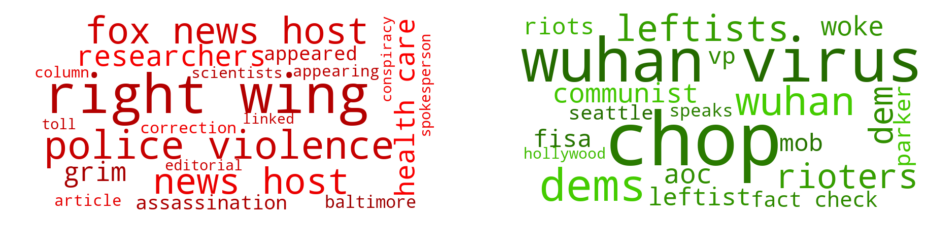

In [215]:
plot_pos_neg_wordclouds(norm_freqs_left, norm_freqs_right)

In [216]:
def plot_allwords_wordclouds(norm_freqs_all):
    wc = WordCloud(width=1200, height=800, background_color="white", max_words=200, min_font_size=10).generate_from_frequencies(norm_freqs_all)

    color_to_words = {
        # left words will be colored with a green single color function
        'blue': norm_freqs_left.keys(),
        # right words will be colored with a red single color function
        'red': norm_freqs_right.keys()
    }

    # Words that are not in any of the color_to_words values
    # will be colored with a grey single color function
    default_color = 'grey'

    # Create a color function with multiple tones
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    # Apply our color function
    wc.recolor(color_func=grouped_color_func)

    plt.figure(figsize=(16,12))

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

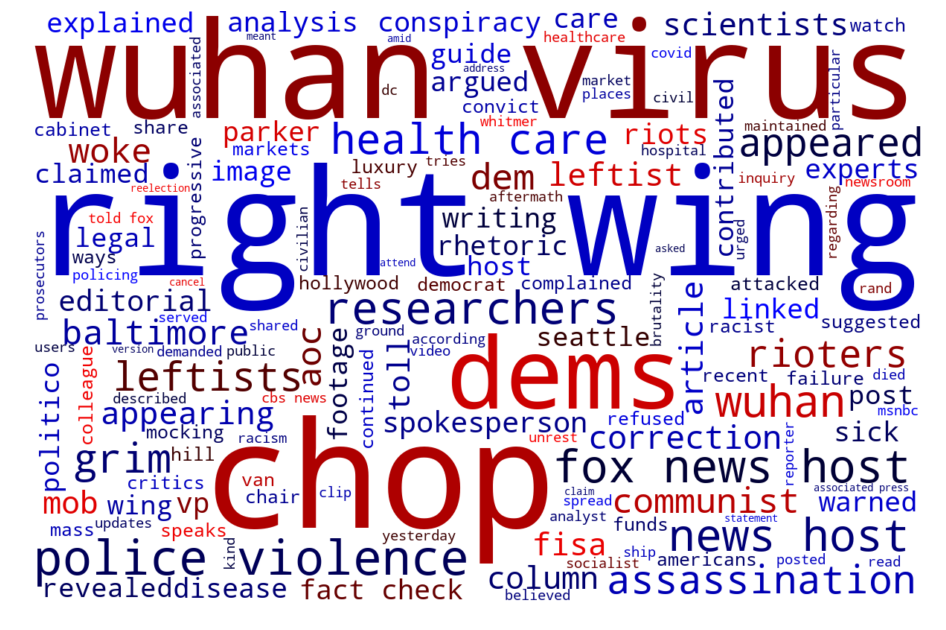

In [217]:
plot_allwords_wordclouds(norm_freqs_all)